In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [2]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any()) #Verifier qu'il n'y a pas d'id en doublon
print(corpus.index.duplicated().any())
corpus

(1825, 6)
0    1825
1    1825
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"Le Baptême symbolise, représente et scelle l’application du sang de Christ sur nous pour retirer la culpabilité de notre péché. La figure utilisée dans le Nouveau Testament pour l’application de ce sang est celle de l’aspersion (Hébreux 9:13, 14, 22; 10:22; 12:24; 1 Pi 1:2). Il serait bien étrange que le baptême d’eau qui représente l’aspersion du sang du Christ ne puisse pas être réalisé par l’aspersion.",baptême symbolise représente scelle application sang christ retirer culpabilité péché figure utilisée nouveau testament application sang celle aspersion hébreux pi bien étrange baptême eau représente aspersion sang christ puisse être réalisé aspersion,baptism,413,0
1,1,"4. MULLER, Richard A., _Dictionary of Latin and Greek Theological_ Terms, 2e éd. (Grand Rapids, Mich.: Baker Academic, 2017), p. 362. Voir aussi la discussion de Muller dans _Post-Reformation Reformed Dogmatics, 1_ :270–284.[↩]",muller richard a dictionary of latin and greek theological terms e éd grand rapids mich baker academic p voir aussi discussion muller post-reformation reformed dogmatics –↩,philosophy,229,1
2,2,"Cela vient du fait que par nature, notre esprit ne connaît l’essence que de ce qui est selon sa façon d’être : Ainsi, l’homme matériel voit très bien les êtres matériels, par les yeux du corps comme ceux de l’esprit . L’ange immatériel voit très bien les êtres immatériels, par les yeux de son esprit. Mais ni l’homme ni l’ange ne peuvent voir naturellement celui qui est l’Être même, dont la façon d’être lui est absolument unique.",cela vient fait nature esprit connaît essence selon façon être ainsi homme matériel voit très bien être matériel yeux corps comme ceux esprit ange immatériel voit très bien être immatériel yeux esprit ni homme ni ange peuvent voir naturellement celui être dont façon être absolument unique,philosophy,437,1
3,3,"Nous constatons dans les Actes (10:48, 16:15, 16:32-34, 18:8) que de nombreuses familles sont baptisées. Ce qui est plus intéressant, c’est de constater que toutes les familles présentes en Actes sont baptisées et que tous les baptêmes de païens sont des baptêmes de famille. La majorité des baptêmes sont des baptêmes de famille. Je pense que Luc ne fait pas l’oeuvre d’un journaliste qui veut simplement « faire du sensationnel ». Il veut communiquer un message théologique : Et si Dieu était enfin en train d’accomplir sa grande promesse faite à Abraham de bénir toutes _les familles_ de la terre en lui (Gen 12:3) ? N’est-ce pas précisément ce que le Messie est venu accomplir (Luc 1:55, 68-73) ?",constatons acte - nombreuses famille baptisé plus intéressant constater toutes famille présente acte baptisé tous baptême païen baptême famille majorité baptême baptême famille pense luc fait oeuvre journaliste veut simplement « faire sensationnel » veut communiquer message théologique si dieu enfin train accomplir grand promesse faite abraham bénir toutes famille terre gen est-ce précisément messie venu accomplir luc -,baptism,709,0
4,4,"Autrement dit, l’expression « toi et ta maison » ne se trouve pas dans les ouvrages « païens » grecs de l’époque du Nouveau Testament. Le Nouveau Testament hérite donc cette expression de l’Ancien, y compris de sa traduction en grec (LXX), il est donc naturel et raisonnable de penser qu’il désigne la même entité que l’Ancien Testament par cette expression : une famille entière, enfants compris.",autrement dit expression « maison » trouve ouvrage « païen » grec époque nouveau testament nouveau testament hérite donc cette expression ancien compris traduction grec lxx donc naturel raisonnable penser désigne entité ancien testament cette expression famille entière enfant compris,baptism,402,0
...,...,...,...,...,...,...
3645,3645,"Rappelez vous ce que l’on disait sur [la simplicité divine](https://phileosophiablog.wordpress.com/2018/01/18/thomas-daquin-sur- la-simplicite-de-dieu/): Dieu n’est pas composé de force, sagesse ou au

In [10]:
from sklearn.svm import SVC

model = SVC()
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
print(indices_test)
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
model.fit(X_train_counts, y_train)

# test du modele
X_test_counts = count_vectorizer.transform(X_test)
y_pred = model.predict(X_test_counts)
print(y_pred)
print(X_test.shape)
print(X_test_counts.shape)

1313    1313
1674    1674
229      229
2974    2974
2222    2222
        ... 
1618    1618
819      819
100      100
3208    3208
3371    3371
Name: id, Length: 1205, dtype: int64
[1 1 1 ... 0 1 0]
(1205,)
(1205, 9779)


C:\Users\eupho\AppData\Local\Temp/ipykernel_10944/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_10944/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

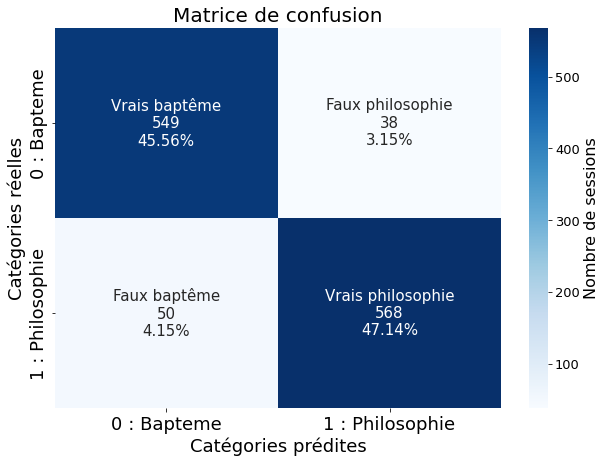

In [12]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [13]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       587
           1       0.94      0.92      0.93       618

    accuracy                           0.93      1205
   macro avg       0.93      0.93      0.93      1205
weighted avg       0.93      0.93      0.93      1205



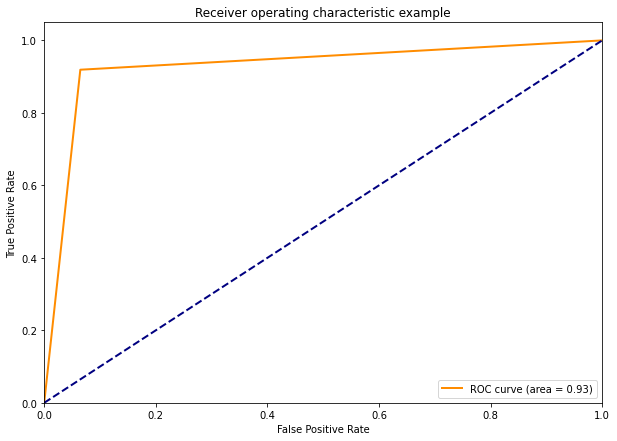

In [14]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [15]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1205, 4)
(88, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [8]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) #aux philosophi

,id,message,message_preprocessed,category,length,category_bin
1436,1436,"[1] _La Didaché ou enseignement des douze apôtres_ , Paragraphe 7, traduction par patristique.org",didaché enseignement douze apôtre paragraphe traduction patristiqueorg,baptism,98,0
170,170,"Précisément, il y a un passage qui le fait, comme je le montrerai dans un article à venir.",précisément a passage fait comme montrerai article venir,baptism,91,0
1647,1647,"Bonjour, un article à venir prouve sans l’ombre d’un doute que Paul a pour but de faire un tel parallèle, je rejette donc votre proposition.",bonjour article venir prouve sans ombre doute paul a but faire tel parallèle rejette donc proposition,baptism,141,0
1281,1281,"4) Dieu n’oppose jamais dans sa Parole la connaissance et l’obéissance. Au contraire, il dit « mon peuple périt par manque de connaissance ».",dieu oppose jamais parole connaissance obéissance contraire dit « peuple périt manque connaissance »,baptism,142,0
3519,3519,"Comment s’adresser à une personne de nos assemblées ? Peut-on lui dire qu’il est enfant de Dieu ? Peut-on dire, comme je l’ai encore entendu ce dimanche, qu’il peut avoir la certitude de retrouver Christ après sa mort ? Peut-on chanter en assemblée « J’ai l’assurance de mon salut » ? Ne savons-nous pas que certains ne croient pas, même parmi les membres officiels et réguliers ?",comment adresser personne assemblée peut-on dire enfant dieu peut-on dire comme encore entendu dimanche peut avoir certitude retrouver christ après mort peut-on chanter assemblée « assurance salut » savons-nous certain croient parmi membre officiel régulier,baptism,384,0
1407,1407,"Oui, et je ne pense pas que sont admissibles à la Cène les non-baptisés.",oui pense admissible cène non-baptisés,baptism,72,0
2228,2228,"Ainsi, je vous invite ici à ne pas vous cacher derrière ce slogan mais à peser les arguments avancés avant de poursuivre par ces réponses aux objections. Il est irrationnel de rejeter un argument valide. Et le fait qu’un argument soit valide ne dépend pas des « lunettes » que nous aurions. La validité est quelque chose d’objectif, de vérifiable car la validité n’est qu’un autre mot pour dire « vérité » et la vérité est objective puisqu’elle tient sa source de Dieu lui-même.",ainsi invite ici cacher derrière slogan peser argument avancés avant poursuivre réponse objection irrationnel rejeter argument valide fait argument valide dépend « lunette » validité quelque chose objectif vérifiable car validité autre mot dire « vérité » vérité objective tient source dieu lui-même,baptism,484,0
1925,1925,"Autrement dit, si l’un de mes arguments ne vous convainc pas, n’en restez pas là ! Essayez de savoir si vous avez raison de ne pas être convaincu, c’est-à- dire, montrez-moi en quoi l’argument n’est pas valide. Avec ces choses en tête, poursuivons.",autrement dit si argument convainc restez là essayez savoir si raison être convaincu est-à- dire montrez-moi quoi argument valide chose tête poursuivons,baptism,251,0
387,387,"Maintenant que nous avons ces éléments bien en tête, nous pouvons revenir à notre texte, Colossiens 2.",maintenant élément bien tête pouvons revenir texte colossiens,baptism,103,0
889,889,"Par exemple, le fait que Christ dise qu’il est venu, non pas pour les justes mais pour les pécheurs me donne de l’assurance. Non pas parce qu’il est écrit « Maxime, tu es élu », mais parce que je sais que je suis pécheur et que Christ est venu précisément pour des gens comme moi. Personne n’est trop pécheur pour Christ, pas même moi.",exemple fait christ dise venu non juste pécheur donne assurance non parce écrit « maxime élu » parce sais pécheur christ venu précisément gens comme personne trop pécheur christ,baptism,339,0


In [9]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id]) #faux bapteme

#faux exemples a enlever : commentaires, description auteur, texte anglais, references bibliographiques

,id,message,message_preprocessed,category,length,category_bin
2866,2866,_Jesus loves me this I know_ _For the Bible tells me so_,jesus loves this i know for the bible tell so,philosophy,60,1
3169,3169,[Maxime N. Georgel](http://www.parlafoi.local) sur 10 janvier 2020 à 17 h 55 min,maxime georgelhttpwwwparlafoilocal janvier heure min,philosophy,81,1
2351,2351,Justifié avec le shema Israël en plus. Trop la classe. Voyons maintenant les arguments qui soutiennent :,justifié shema israël plus trop classe voyons maintenant argument soutiennent,philosophy,105,1
393,393,"Si Marie avait des enfants après Jésus, cela porterait atteinte à sa perfection : tout comme il était fils unique de son père, il convenait qu’il soit fils unique de sa mère.",si marie enfant après jésus cela porterait atteinte perfection tout comme fil unique père convenait fil unique mère,philosophy,176,1
1729,1729,"Par exemple, prenons le sel marin (constitué de NaCl : Sodium et Chlore). Comme le dit Berthelot (le père de la synthèse chimique) « L’analyse du sel marin conduit à le décomposer en deux éléments, le chlore et le sodium : les propriétés de ces deux éléments ne présentent aucune analogie avec celles du sel marin. En effet, d’une part, le chlore est un gaz jaune, doué de propriétés décolorantes et d’une extrême activité chimique ; d’autre part, le sodium est un métal, doué d’un aspect argentin, plus léger que l’eau, apte à décomposer ce liquide dès la température ordinaire. On voit combien ces éléments ressemblent peu au sel marin, matière solide, blanche, cristalline, dissoluble dans l’eau. » La seule façon d’expliquer comment un gaz corrosif peut donner du sel de table, c’est de faire appel à une forme substantielle qui _informe_ différemment cette matière, en lui donnant des propriétés différentes que si le chlore et le sodium étaient séparées.",exemple prenons sel marin constitué nacl sodium chlore comme dit berthelot père synthèse chimique « analyse sel marin conduit décomposer deux élément chlore sodium propriété deux élément présentent aucune analogie celles sel marin effet part chlore gaz jaune doué propriété décolorantes extrême activité chimique autre part sodium métal doué aspect argentin plus léger eau apte décomposer liquide dès température ordinaire voit combien élément ressemblent peu sel marin matière solide blanche cristalline dissoluble eau » seule façon expliquer comment gaz corrosif peut donner sel table faire appel forme substantielle informe différemment cette matière donnant propriété différentes si chlore sodium séparées,philosophy,972,1
1075,1075,"Je ne reçois pas l’argument 2, parce qu’ils sont le relais d’une vision de la sexualité comme intrinsèquement perverse que je ne reçois pas. Au point où j’en suis, j’ai même du mal à comprendre des excès comme ceux de Méthode d’Olympie, mis à part en blâmant le platonisme présent chez les pères.",reçois argument parce relais vision sexualité comme intrinsèquement pervers reçois point où mal comprendre excès comme ceux méthode olympie mis part blâmant platonisme présent chez père,philosophy,299,1
1840,1840,"Tout au long de son ministère, le Dr R.C. Sproul a critiqué avec bienveillance le présuppositionnalisme de Cornelius Van Til. Quand je dis que le Dr Sproul était un critique « amical », je veux dire qu’il a reconnu que Van Til et ceux qui se considèrent « Van Tilliens » dans leur approche à l’apologétique, ou la défense de la foi, sont des frères en Christ. Dans sa jeunesse, le Dr Sproul a passé du temps avec Van Til, et par la suite, il a toujours dit que Van Til était un homme de Dieu. Beaucoup d’autres ont dit la même chose de Van Til, et il n’y a aucune raison de douter de leurs jugements. Le Dr Sproul admirait le caractère chrétien de Van Til, mais il a cependant critiqué certains points de son enseignement. Il estimait que la doctrine de Van Til contenait de graves erreurs et incompréhensions1. Je pense que le Dr Sproul avait certainement raison aussi bien dans son évaluation du 